In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

### Importing Datasets

In [2]:

rating_cols = ['user_id' , 'item_id' , 'rating', 'timestamp']
rating_data = pd.read_csv("u.data", sep='\t', names=rating_cols,encoding='latin-1') 
rating_base = pd.read_csv("ua.base", sep='\t', names=rating_cols, encoding='latin-1')
rating_test = pd.read_csv("ua.test", sep='\t', names=rating_cols, encoding='latin-1')


# Part 1

### Histograms

In [315]:
from collections import Counter
item_freqs = Counter(rating_data['item_id'] )
user_freqs = Counter(rating_data['user_id'] )

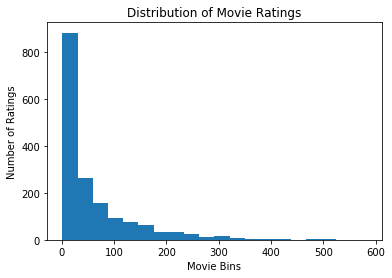

In [322]:
plt.hist(list(item_freqs.values()), bins = 20)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Movie Bins")
plt.ylabel("Number of Ratings")
plt.show()

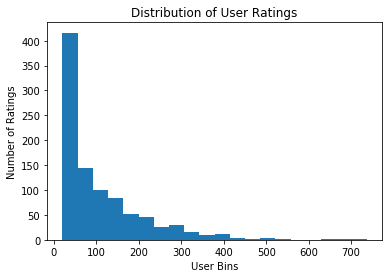

In [327]:
plt.hist(list(user_freqs.values()), bins = 20)
plt.title("Distribution of User Ratings")
plt.xlabel("User Bins")
plt.ylabel("Number of Ratings")
plt.show()

### Building a U by I matrix A, where U is the number of users, and I is the number of rated movies

In [5]:
def matrix_convertor(df, y = 943,z = 1682):
    A = np.zeros((y,z))
    flat_list = []
    for i in range(df.shape[0]):
        flat_list.append( list(df.iloc[i]))
    for j in range(len(flat_list)):
        row_idx = flat_list[j][0]-1 
        col_idx = flat_list[j][1]-1
        val = flat_list[j][2]
        A[row_idx][col_idx] = val
    return A

In [6]:
A_base = matrix_convertor(rating_base)
A_test = matrix_convertor(rating_test)

# Part 2: Build a recommender system where the baseline predictor for a (u,i) pair is:  $b_{ui}=μ+b_u+b_i$

## 2.a) Estimate  $μ$, $b_u$, $b_i$ empirically and compute the means square error on the test set 

Based on Section 4.1 on paper [2], we take $λ_2 = 25$  and $λ_3 = 10$

In [7]:
lambda2 = 25
lambda3 = 10

Calculating $μ$:

In [8]:
mu = np.mean(rating_base["rating"])

Calculating $b_i$ & $b_u$

In [9]:
b_i = []
b_u = []
for i in range(1682):
    b_ii = 0
    mod_R = np.count_nonzero(A_base[:, i])     
    for u in range(943):
        if A_base[u,i]>0:
            b_ii+= A_base[u,i] - mu
    b_i.append(b_ii/(lambda2 + mod_R))


for u in range(943):
    b_uu = 0
    mod_R = np.count_nonzero(A_base[u, :])    
    for i in range(1682):
        if A_base[u,i]>0:
            b_uu+= A_base[u,i] - mu - b_i[i]
    b_u.append(b_uu/(mod_R + lambda3) )
        
    

Calculating $b_{ui}$

In [10]:
b_ui = np.zeros((943, 1682))#A_base.shape)
b_i = np.array(b_i)
b_u = np.array(b_u)
for i in range(1682):
    for u in range(943):    
        b_ui[u,i] = mu + b_i[i] + b_u[u]

Calculating RMSE 

In [11]:
errors = []
for u in range (943):
    for i in range (1682):
        if A_test[u,i]>0 :
            errors.append((A_test[u,i]-b_ui[u,i])**2)
RMSE = np.sqrt(np.mean(errors))
RMSE

0.96648178388792516

## Plot the RMSE per user

We will calculate the average of the all ratings given by a user, and then segment the users into 5 bins based on the range of average values. 

In [209]:
user_averages = A_base.sum(1)/(A_base!=0).sum(1)

In [211]:
print("The user averages range from ",min(user_averages)," to ", max(user_averages))


The user averages range from  1.48941176471  to  4.92857142857


We will now record the users who fall into each of the five bins.

In [273]:
start_val = min(user_averages)
end_val = max(user_averages)
interval = (end_val - start_val)/5
bin_1 = []
bin_2 = []
bin_3 = []
bin_4 = []
bin_5 = []

print ("Bin 1: {} - {} ".format( round(start_val,2), round(start_val + interval,2)  ))
print ("Bin 2: {} - {} ".format( round(start_val + interval,2), round(start_val + interval*2,2)  ))
print ("Bin 3: {} - {} ".format( round(start_val+ interval*2,2),round( start_val + interval*3 ,2) ))
print ("Bin 4: {} - {} ".format( round(start_val+ interval*3,2), round(start_val + interval*4 ,2) ))
print ("Bin 5: {} - {} ".format( round(start_val+ interval*4,2), round(start_val + interval*5,2)  ))


for j in range(len(user_averages)):
    if user_averages[j]>= end_val - interval:
        bin_5.append(j)
    elif  user_averages[j]>= end_val - 2*interval:
        bin_4.append(j)
    elif  user_averages[j]>= end_val - 3*interval:
        bin_3.append(j)
    elif  user_averages[j]>= end_val - 4*interval:
        bin_2.append(j)
    else:
        bin_1.append(j)    
    

Bin 1: 1.49 - 2.18 
Bin 2: 2.18 - 2.87 
Bin 3: 2.87 - 3.55 
Bin 4: 3.55 - 4.24 
Bin 5: 4.24 - 4.93 


Defining a function to calculate RMSE:

In [213]:
def user_rmse(user_bin, result_set = b_ui, test_set = A_test, movie_qty = 1682):
    RMSE = []
    for u in user_bin:
        RMSE_u = []
        for i in range(movie_qty):
            
            if test_set[u,i]>0:
                RMSE_u.append( (result_set[u,i] - test_set[u,i] )**2 )
                
 
        RMSE.append( np.sqrt(np.mean(RMSE_u)))
    return RMSE
        

In [260]:
RMSE_Bin = []
RMSE_Bin.append(np.mean(user_rmse(bin_1)))
RMSE_Bin.append(np.mean(user_rmse(bin_2)))
RMSE_Bin.append(np.mean(user_rmse(bin_3)))
RMSE_Bin.append(np.mean(user_rmse(bin_4)))
RMSE_Bin.append(np.mean(user_rmse(bin_5)))

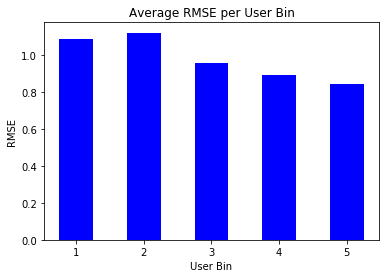

In [261]:
plt.bar(range(1,6), RMSE_Bin, width = 0.5, color="blue")
title = "Average RMSE per User Bin"
plt.title(title)
plt.xlabel("User Bin")
plt.ylabel("RMSE")
plt.show()

## Build a recommender system based on reference paper [2] section 4.2

We will define an item-based KNN algorithm below.


In [21]:
similarity = np.zeros((1682, 1682))

for i1 in range(1682):
    for i2 in range(1682):
        R_u = []
        R_u1 = []
        R_u2 = []
        for u in range(943):
            if A_base[u,i1]>0 and A_base[u,i2]>0 and i1<i2:
                R_u.append(user_averages[u])
                R_u1.append(A_base[u,i1])
                R_u2.append(A_base[u,i2])
                
        R_u = np.array(R_u)
        R_u1 = np.array(R_u1)
        R_u2 = np.array(R_u2)
        numerator = np.sum( (R_u1 - R_u) * (R_u2 -R_u) )
        denominator = np.sqrt(np.sum( (R_u1 - R_u)**2 ) * np.sum( (R_u2 - R_u)**2 ))
        if denominator!= 0 :
            similarity[i1, i2] = numerator/denominator


## Implementing KNN


In [155]:
A_test_new = np.zeros((A_test.shape))
x, y = np.nonzero(A_test)
k = [1,2,3,5,10]

K =  1 

Test RMSE: 1.37467880778
RMSE for Bin 1 : 1.30636352524
RMSE for Bin 2 : 1.5417697786
RMSE for Bin 3 : 1.389428966
RMSE for Bin 4 : 1.27153527906
RMSE for Bin 5 : 1.00704006969


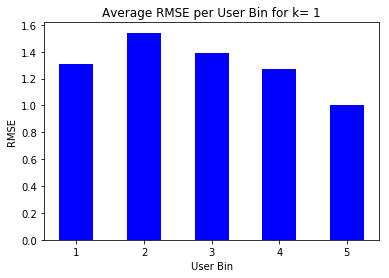


--------------------------------------------------------------------------------------------

K =  2 

Test RMSE: 1.20083553729
RMSE for Bin 1 : 1.24334223327
RMSE for Bin 2 : 1.38786664135
RMSE for Bin 3 : 1.21024702245
RMSE for Bin 4 : 1.10898295937
RMSE for Bin 5 : 0.900290220352


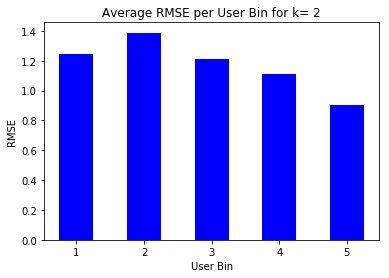


--------------------------------------------------------------------------------------------

K =  3 

Test RMSE: 1.14101464762
RMSE for Bin 1 : 1.19170073774
RMSE for Bin 2 : 1.3269481024
RMSE for Bin 3 : 1.13790378633
RMSE for Bin 4 : 1.06203623591
RMSE for Bin 5 : 0.866248454169


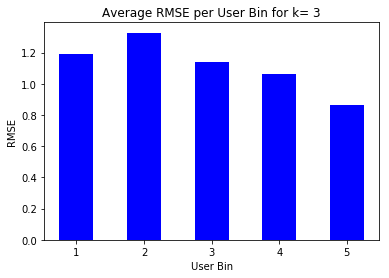


--------------------------------------------------------------------------------------------

K =  5 

Test RMSE: 1.08929466622
RMSE for Bin 1 : 1.12774952641
RMSE for Bin 2 : 1.27707778324
RMSE for Bin 3 : 1.08489878019
RMSE for Bin 4 : 1.01269150543
RMSE for Bin 5 : 0.858328396483


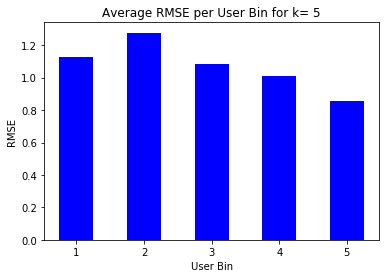


--------------------------------------------------------------------------------------------

K =  10 

Test RMSE: 1.1800027658
RMSE for Bin 1 : 1.33607598278
RMSE for Bin 2 : 1.45768725391
RMSE for Bin 3 : 1.10197494739
RMSE for Bin 4 : 1.03110959586
RMSE for Bin 5 : 1.04540509237


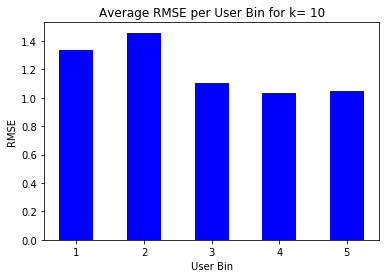


--------------------------------------------------------------------------------------------



In [285]:
RMSE = []
for kk in k: 
    for uu,ii in zip(x,y):
        
        base_idx = np.nonzero(A_base[uu,:]) #nonzero elements in A_base
        base_idx = base_idx[0]
        top_i = similarity[ii,base_idx].argsort()[-kk:][::-1]
        base_idx = base_idx[top_i] 
        dist = similarity[ii, base_idx]
        numerator = np.sum((A_base[uu,base_idx] * dist))
        
        denominator = np.sum(abs(dist))
        
        if denominator!=0:
            A_test_new[uu,ii] = numerator/denominator
        else:
            A_test_new[uu,ii] =  (A_base.sum(1)/(A_base!=0).sum(1))[uu]
            
    
    base_idx2 = np.nonzero(A_test)  
    RMSE_k = np.sqrt(np.sum(np.square(A_test_new[base_idx2] - A_test[base_idx2]))/len(A_test[base_idx2]))
    RMSE.append(RMSE_k)
    
    RMSE_Bin = []
    RMSE_Bin.append(np.mean(user_rmse(bin_1, result_set = A_test_new, test_set = A_test, movie_qty = 1682)))
    RMSE_Bin.append(np.mean(user_rmse(bin_2, result_set = A_test_new, test_set = A_test, movie_qty = 1682)))
    RMSE_Bin.append(np.mean(user_rmse(bin_3, result_set = A_test_new, test_set = A_test, movie_qty = 1682)))
    RMSE_Bin.append(np.mean(user_rmse(bin_4, result_set = A_test_new, test_set = A_test, movie_qty = 1682)))
    RMSE_Bin.append(np.mean(user_rmse(bin_5, result_set = A_test_new, test_set = A_test, movie_qty = 1682)))
    
    
    print("K = ", kk, "\n")
    print("Test RMSE:", RMSE_k)
    for idx in range(len(RMSE_Bin)):
        
        print("RMSE for Bin", idx+1,":", RMSE_Bin[idx])
    
    
    
    plt.bar(range(1,6), RMSE_Bin, width = 0.5, color="blue")
    title = "Average RMSE per User Bin for k= %s" %(kk )
    plt.title(title)
    plt.xlabel("User Bin")
    plt.ylabel("RMSE")
    plt.show()
    print("\n--------------------------------------------------------------------------------------------\n") 

The lowest test RMSE is observed for k = 5